In [297]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from scipy.optimize import fsolve

In [298]:
def pendulum(x,u,param):
    m1 = param[0]
    m2 = param[1]
    # x[0] = y; x[1] = v, x[2] = thetha; x[3] = q
    eta = m2/(m1+m2)
    
    dxdt = [0.]*4
    dxdt[0] = x[1]
    dxdt[1] = eta*x[2] + u[0]
    dxdt[2] = x[3]
    dxdt[3] = -x[2] - u[0]
    return dxdt
    

In [299]:
# Getting the steady state
us = [0]
parameter = [10, 5]
f = lambda x: pendulum(x, us, parameter)
xs = fsolve(f, [2, 0, 0, 0])

print(f'xs = {xs}')
print(pendulum(xs, us, parameter))

xs = [2. 0. 0. 0.]
[0.0, 0.0, 0.0, -0.0]


In [300]:
# Parameters of the simulation
N=201
dt = 0.1

In [301]:
# Defining symbolics of casadi
t = SX.sym("t", 1, 1)
x = SX.sym("x", 4, 1)
u = SX.sym("u", 1, 1)

ode = vertcat(*pendulum(x, u, parameter))
print(ode)

[x_1, ((0.333333*x_2)+u), x_3, (-(x_2+u))]


In [302]:
f = {'x': x, 't': t, 'p':u, 'ode':ode}
Phi = integrator("Phi", "cvodes", f, {'tf': dt})

In [303]:
system = Phi

num_time_steps_sim = 200  # number of time steps in simulation
# Time array for plotting
time = [i*dt for i in range(num_time_steps_sim+1)]
len(time)

201

In [304]:
q = vertcat(*[MX.sym(f'u{i}', 1, 1) for i in range(N)])
s = vertcat(*[MX.sym(f'x{i}', 4, 1) for i in range(N+1)])
z = []
zlb = []
zub = []
constraints = []

# Creating the function to optimize
cost = 0.
Q = np.eye(4)
R = np.eye(1)*0.1
ulb = [-0.2]
uub = [0.2]

In [305]:
for i in range(N):
    s_i = s[4*i:4*(i+1)]
    s_ip1 = s[4*(i+1):4*(i+2)]
    q_i = q[1*i:1*(i+1)]
    
    #decision variable
    zlb+= [-np.inf] * 4
    zub += [np.inf] * 4    
    zlb += ulb
    zub += uub
    z.append(s_i)
    z.append(q_i)
    
    xt_ip1 = Phi(x0 = s_i, p = q_i)['xf']
    #cost += s_i.T @ Q + q_i.T @ R
    cost += s_i.T @ Q @ s_i + q_i.T @ R @ q_i
    constraints.append(xt_ip1 - s_ip1)
    
# s_N
z.append(s_ip1)
zlb += [-np.inf] * 4
zub += [np.inf] * 4

constraints = vertcat(*constraints)
variables = vertcat(*z) 

final = np.zeros(len(time))
for i in time:
    if i>= 6.2:
        final = 1
    else:
        final = 0
cost = cost*final 

In [306]:
# Create the optmization problem
g_bnd = np.zeros(N*4)
nlp = {'f': cost, 'g': constraints, 'x': variables}
opt = {'print_time': 0, 'ipopt.print_level': 0}
solver = nlpsol('solver', 'ipopt', nlp, opt)

def solve_mpc(current_state):
    """Solve MPC provided the current state, i.e., this 
    function is u = h(x), which is the implicit control law of MPC.
    
    Args:
        current_state (array-like): current state
    
    Returns:
        tuple: current input and return status pair
    """
    
    # Set the lower and upper bound of the decision variable
    # such that s0 = current_state
    for i in range(4):
        zlb[i] = current_state[i]
        zub[i] = current_state[i]
    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_bnd, ubg=g_bnd)
    #print(sol_out['x'][4])
    return (np.array(sol_out['x'][4]), solver.stats()['return_status'])

In [307]:
num_time_steps_sim = 200  # number of time steps in simulation

# Store the system states and control actions applied to the system
# in array
state_history = np.zeros((num_time_steps_sim+1, 4))
input_history = np.zeros((num_time_steps_sim+1, 1))



In [308]:
# Set current state - using deviation variables
state_history[0, :] = np.array([0.0, 0.0, 0.0, 0.0]) - xs
current_state = state_history[0, :]

# Time array for plotting
time = [i*dt for i in range(num_time_steps_sim+1)]
len(time)


201

In [309]:
# Closed-loop simulation
for k in range(num_time_steps_sim):
    
    print(f'Current time: {k*dt}')
    current_control, status = solve_mpc(current_state)
    print(f'Solver status: {status}')
    print(current_control)
    
    # Advance the simulation one time step
    # Set current_state to be the state at the next time steps
    current_state = np.array(system(x0=current_state, p=current_control)['xf'])
    
    current_state = current_state.reshape((4,))
    current_control = current_control.reshape((1,))
    
     # Save data for plotting
    input_history[k, :] = current_control
    state_history[k+1:k+2, :] = current_state

# Save the last control one more time for plotting
input_history[-1, :] = current_control

Current time: 0.0
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.1
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.2
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.30000000000000004
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.4
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.5
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.6000000000000001
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.7000000000000001
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.8
Solver status: Solve_Succeeded
[[0.2]]
Current time: 0.9
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.0
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.1
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.2000000000000002
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.3
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.4000000000000001
Solver status: Solve_Succeeded
[[0.2]]
Current time: 1.5
Solver status: Solve_Succeeded
[[0.2]]
Current time

Solver status: Solve_Succeeded
[[0.05489032]]
Current time: 12.200000000000001
Solver status: Solve_Succeeded
[[0.05523197]]
Current time: 12.3
Solver status: Solve_Succeeded
[[0.05530759]]
Current time: 12.4
Solver status: Solve_Succeeded
[[0.05513001]]
Current time: 12.5
Solver status: Solve_Succeeded
[[0.05471265]]
Current time: 12.600000000000001
Solver status: Solve_Succeeded
[[0.05406941]]
Current time: 12.700000000000001
Solver status: Solve_Succeeded
[[0.05321448]]
Current time: 12.8
Solver status: Solve_Succeeded
[[0.05216241]]
Current time: 12.9
Solver status: Solve_Succeeded
[[0.05092798]]
Current time: 13.0
Solver status: Solve_Succeeded
[[0.04952603]]
Current time: 13.100000000000001
Solver status: Solve_Succeeded
[[0.04797147]]
Current time: 13.200000000000001
Solver status: Solve_Succeeded
[[0.04627914]]
Current time: 13.3
Solver status: Solve_Succeeded
[[0.04446379]]
Current time: 13.4
Solver status: Solve_Succeeded
[[0.04253997]]
Current time: 13.5
Solver status: Solve

Text(0.5, 0, 'Time')

<Figure size 1008x1008 with 0 Axes>

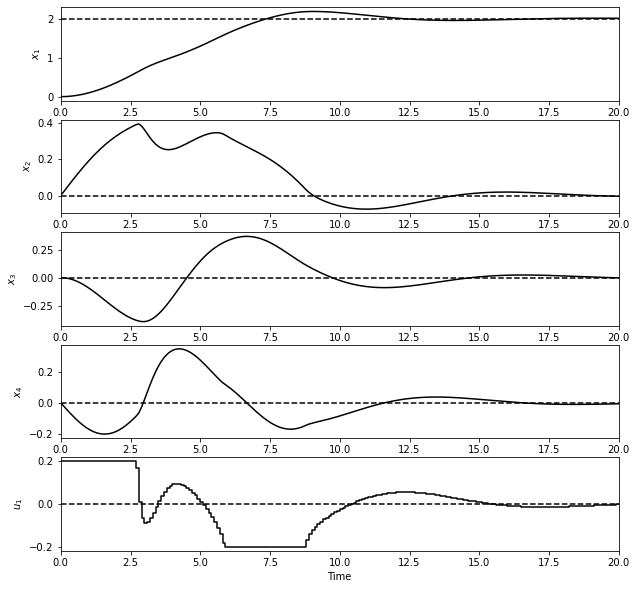

In [310]:
# Figure
plt.figure(figsize=[14, 14])
fig, axs = plt.subplots(5, 1, figsize=[10, 10])
t_max =  max(10, num_time_steps_sim*dt)
for j in range(4):
    axs[j].plot(time, state_history[:, j]+xs[j], 'k-', 
                [time[0], time[-1]], [xs[j], xs[j]], 'k--')
    axs[j].set_ylabel(f'$x_{j+1}$')
    axs[j].set_xlim([0, t_max])

for j in range(1):
    axs[j+4].step(time, input_history[:, j]+us[j], 'k-', 
                  [time[0], time[-1]], [us[j], us[j]], 'k--',
                  where='post')
    axs[j+4].set_ylabel(f'$u_{j+1}$')
    axs[j+4].set_xlim([0, t_max])
axs[-1].set_xlabel('Time')

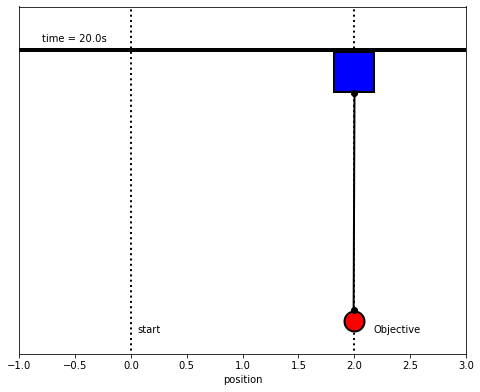

In [296]:
import matplotlib.animation as animation
from IPython.display import HTML

x1 = state_history[:, 0]+xs[0]
y1 = np.zeros(len(time))

#suppose that l = 1
x2 = 1*np.sin(state_history[:, 2]+xs[2])+x1
x2b = 1.05*np.sin(state_history[:, 2]+xs[2])+x1
y2 = -1*np.cos(state_history[:, 2]+xs[2])+y1
y2b = -1.05*np.cos(state_history[:, 2]+xs[2])+y1

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1,3),ylim=(-1.2,0.4))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-1,3],[0.2,0.2],'k-',lw=4)
start, = ax.plot([0,0],[-1.5,1],'k:',lw=2)
objective, = ax.plot([2,2],[-1.5,1],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='blue',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='red',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='black',lw=2,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
start_text = ax.text(2.6,-1.1,'Objective',ha='right')
end_text = ax.text(0.06,-1.1,'start',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]+0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % time[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, np.arange(1,len(time)), interval=40,blit=False,init_func=init)

ani_a.save('Pendulum_Control_30.mp4', fps=30)

plt.show()